In [21]:
### For Colab, install dependencies.

!pip install --upgrade mxnet~=1.7
!pip install gluonts
!pip install fredapi
!pip install stats-can
!pip install --upgrade scikit-learn

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
!pwd

/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting


In [24]:
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [25]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting/output/nbeats_202110"

## Load Data Using APIs

In [26]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# NBEATS Model and Experiments

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [27]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [28]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

## Fitting and Evaluating a Single NBEATS Model: Example Using All Food Prices

In [29]:
N = foodprice_df.shape[1]
T = foodprice_df.shape[0]
prediction_length = 18
freq = "1M"
dataset = foodprice_df.T.values
start = pd.Timestamp("2016-07-01", freq=freq)

In [30]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset[:, :-prediction_length]],
    freq=freq
)
# valid dataset: use the whole dataset, add "target" and "start" fields
valid_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset],
    freq=freq
)



In [36]:
import mxnet as mx
from gluonts.model.n_beats import NBEATSEstimator
from gluonts.mx import Trainer

estimator = NBEATSEstimator(
      prediction_length=prediction_length,
      #context_length=7*prediction_length,
      num_stacks = 30,
      widths= [512],
      freq=freq,
      trainer=Trainer(
                    # learning_rate=1e-3,
                    #clip_gradient=1.0,
                    epochs=10, #10
                    # num_batches_per_epoch=100,
                    # batch_size=16,
                    # ctx=mx.context.gpu()
                )

  )

In [37]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:08<00:00,  6.08it/s, epoch=10/10, avg_epoch_loss=0.17]


Number of sample paths: 100
Dimension of samples: (100, 18)
Start date of the forecast window: 2050-09-30 00:00:00
Frequency of the time series: 1M
Mean of the future window:
 [163.0955  158.69928 157.17754 156.26466 156.97557 163.22192 159.26347
 162.39473 159.36818 162.32912 158.20897 160.45137 163.709   164.64043
 158.98335 161.37871 166.7668  163.91212]
0.5-quantile (median) of the future window:
 [163.09537 158.69942 157.17741 156.26476 156.97548 163.22215 159.2634
 162.39488 159.36829 162.32922 158.20894 160.45143 163.70908 164.64029
 158.98323 161.37857 166.76688 163.91223]


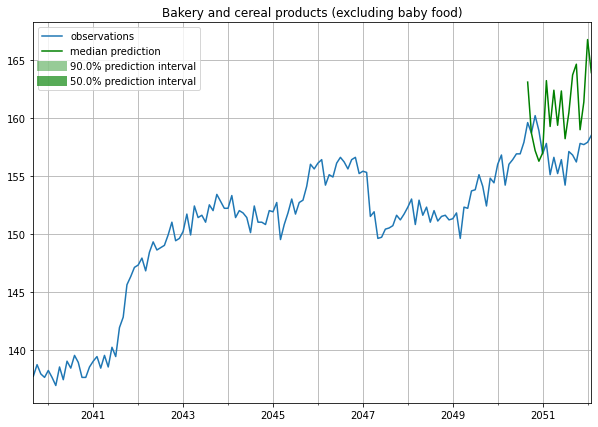

In [39]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

# first entry of the time series list
ts_entry = tss[0]

# first entry of the forecast list
forecast_entry = forecasts[0]
foodprice_category = foodprice_df.columns[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(foodprice_category)
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [40]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [41]:
report_sim_date = "2016-07-01"
report_train_dates = sim_train_dates[report_sim_date]
report_valid_dates = sim_valid_dates[report_sim_date]

valid_df = get_prophet_df(foodprice_df, foodprice_category, report_valid_dates)
valid_forecast = pd.DataFrame(pd.Series(forecast_entry.mean, index=valid_df.index, name='yhat'))

{metric_name: metric_fn(y_true=valid_df.y, y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

{'mae': 9.380040486653646,
 'mape': 0.061918491940914575,
 'mse': 95.75919445781656,
 'r2_score': -55.28397613441036,
 'rmse': 9.785662698959971}

In [ ]:
report_sim_date = "2016-07-01"
report_train_dates = sim_train_dates[report_sim_date]
report_valid_dates = sim_valid_dates[report_sim_date]
train_df = get_prophet_df(foodprice_df, 'Meat', report_train_dates)
train_df

,ds,y
0,1986-01-01,65.1
1,1986-02-01,64.2
2,1986-03-01,64.2
3,1986-04-01,63.6
4,1986-05-01,64.0
...,...,...
362,2016-03-01,160.0
363,2016-04-01,158.7
364,2016-05-01,159.1
365,2016-06-01,156.7


In [ ]:
valid_df = get_prophet_df(foodprice_df, 'Meat', report_valid_dates)
valid_forecast = model.predict(valid_df[['ds']])

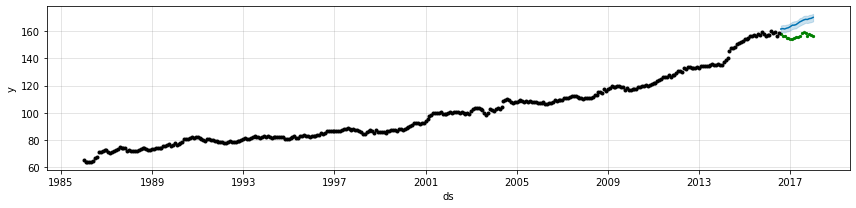

In [ ]:
# valid_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = model.plot(valid_forecast, figsize=(12,3))
fig.axes[0].scatter(valid_df.ds, valid_df.y, color='green', s=5)
pass

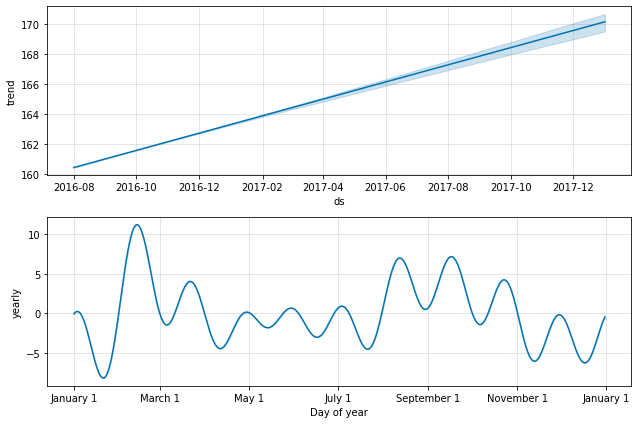

In [ ]:
model.plot_components(valid_forecast)
pass

In [ ]:
{metric_name: metric_fn(y_true=valid_df.y, y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

{'mae': 9.075009905878288,
 'mape': 0.05800690457563521,
 'mse': 88.50885555398541,
 'r2_score': -40.9424167780542,
 'rmse': 9.40791451672396}

## Fit and Evaluate Models for All CPI Categories (Validation)

In [ ]:
def fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates):
    train_df = get_prophet_df(foodprice_df, food_category, train_dates)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(foodprice_df, food_category, valid_dates)     # Select the validation data. 
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast. 

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics. 
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [ ]:
def plot_valid_forecast(model, food_category, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Validation) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_valid_{food_category}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_valid_{food_category}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


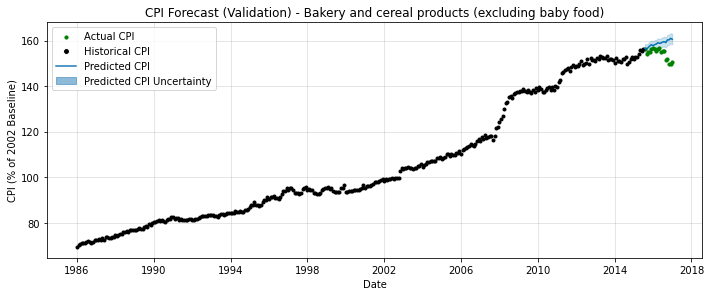

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.44
mae          4.43
mape         0.03
mse         31.43
rmse         5.61
dtype: float64


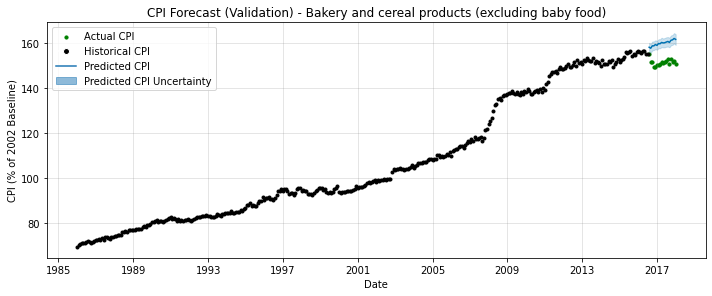

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -43.83
mae          8.57
mape         0.06
mse         76.27
rmse         8.73
dtype: float64


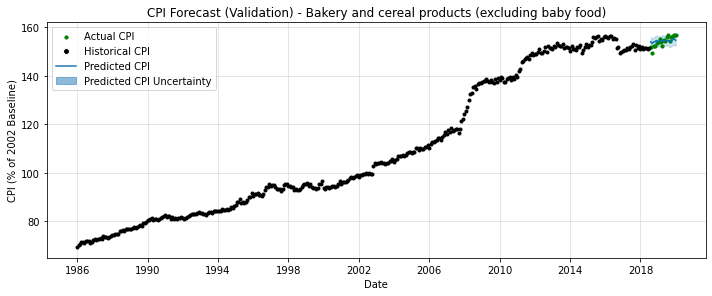

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    2.74e-01
mae         1.41e+00
mape        9.18e-03
mse         2.90e+00
rmse        1.70e+00
dtype: float64


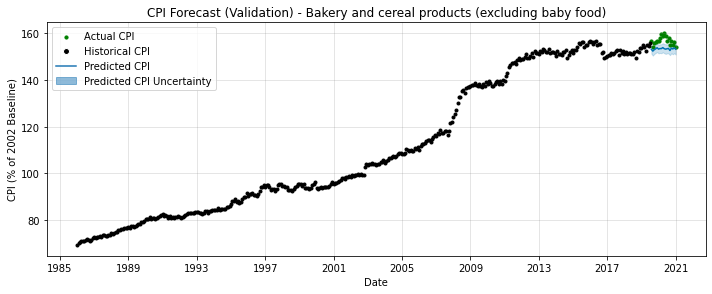

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.56
mae          3.61
mape         0.02
mse         15.23
rmse         3.90
dtype: float64


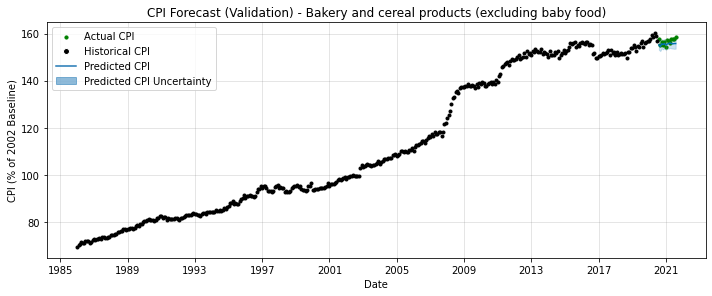

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -6.81e-01
mae         1.35e+00
mape        8.56e-03
mse         2.54e+00
rmse        1.60e+00
dtype: float64


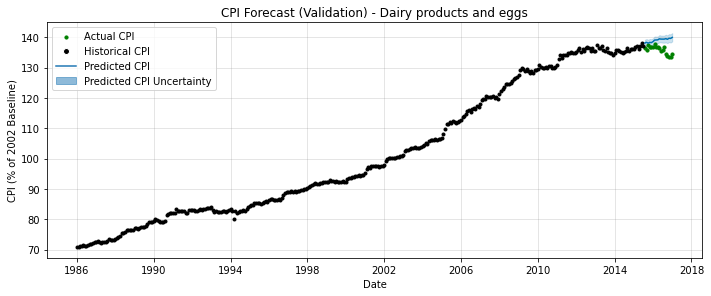

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.67
mae          3.16
mape         0.02
mse         12.92
rmse         3.59
dtype: float64


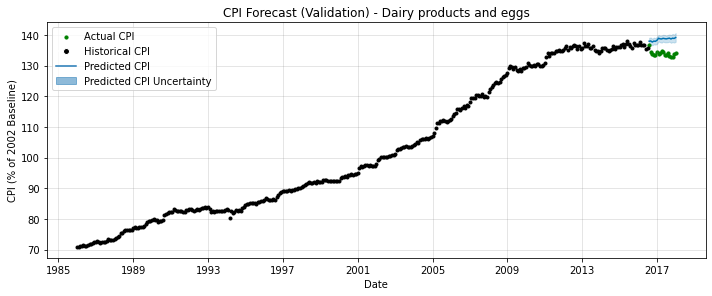

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -29.77
mae          4.62
mape         0.03
mse         22.54
rmse         4.75
dtype: float64


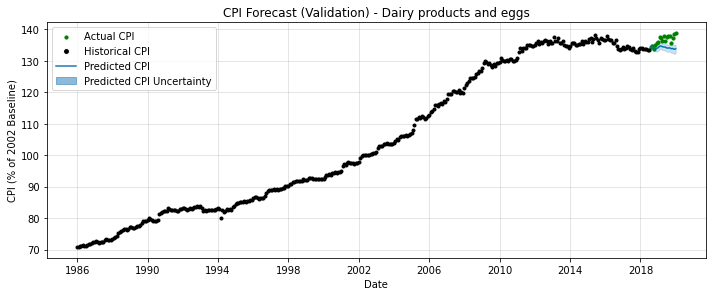

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.62
mae         2.42
mape        0.02
mse         7.98
rmse        2.83
dtype: float64


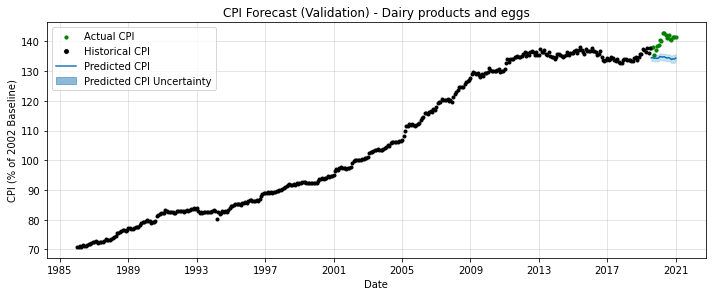

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.83
mae          5.75
mape         0.04
mse         37.13
rmse         6.09
dtype: float64


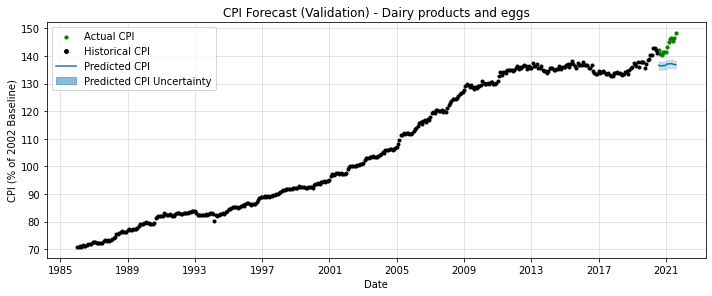

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.54
mae          6.93
mape         0.05
mse         53.34
rmse         7.30
dtype: float64


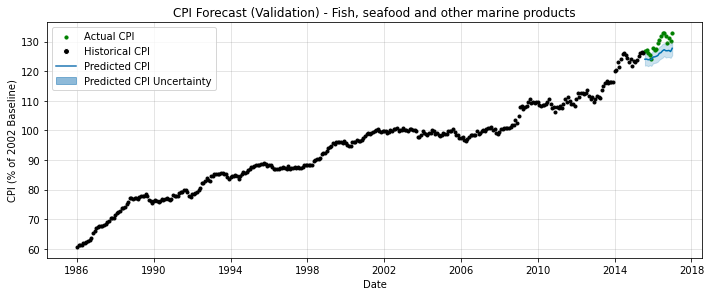

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.07
mae          3.54
mape         0.03
mse         14.88
rmse         3.86
dtype: float64


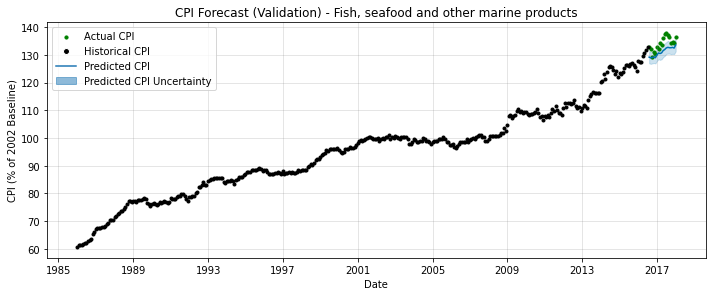

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -0.78
mae          2.96
mape         0.02
mse         10.79
rmse         3.28
dtype: float64


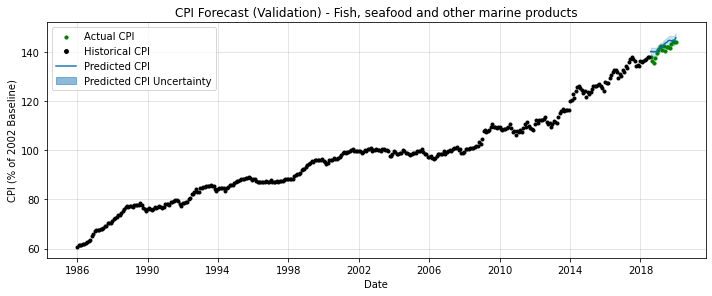

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.30
mae         1.73
mape        0.01
mse         4.62
rmse        2.15
dtype: float64


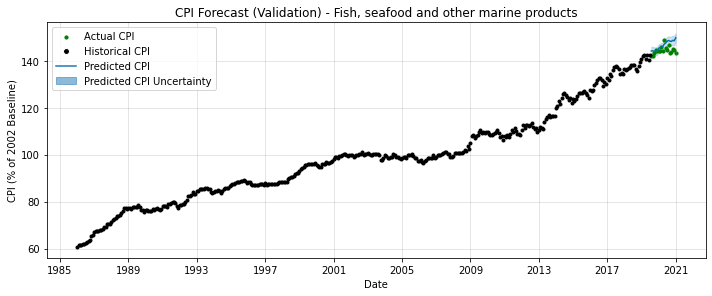

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.41
mae         2.42
mape        0.02
mse         8.88
rmse        2.98
dtype: float64


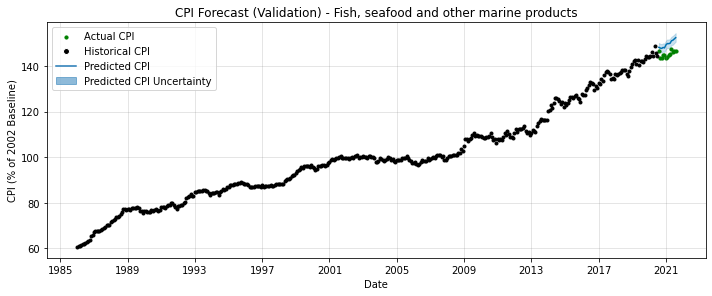

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -10.26
mae          4.44
mape         0.03
mse         21.31
rmse         4.62
dtype: float64


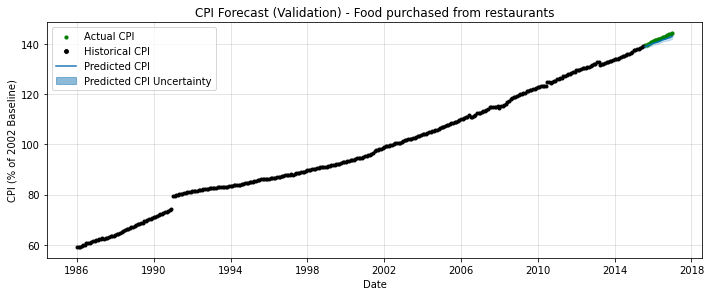

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    5.48e-01
mae         9.73e-01
mape        6.84e-03
mse         1.03e+00
rmse        1.01e+00
dtype: float64


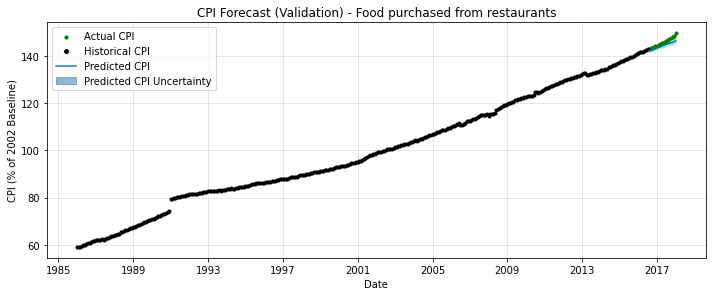

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    3.06e-01
mae         1.42e+00
mape        9.69e-03
mse         2.43e+00
rmse        1.56e+00
dtype: float64


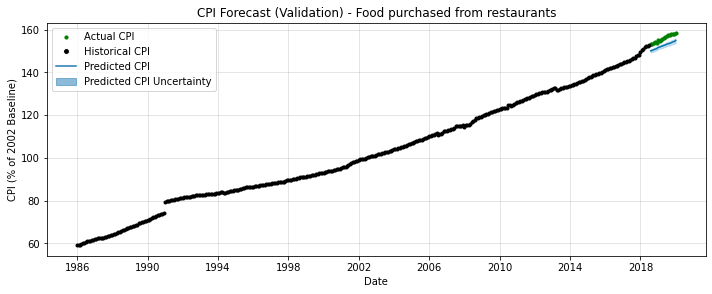

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -3.01
mae          3.44
mape         0.02
mse         11.99
rmse         3.46
dtype: float64


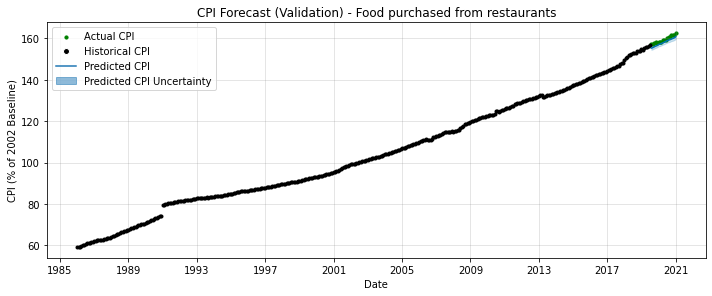

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    1.50e-01
mae         1.44e+00
mape        9.04e-03
mse         2.23e+00
rmse        1.49e+00
dtype: float64


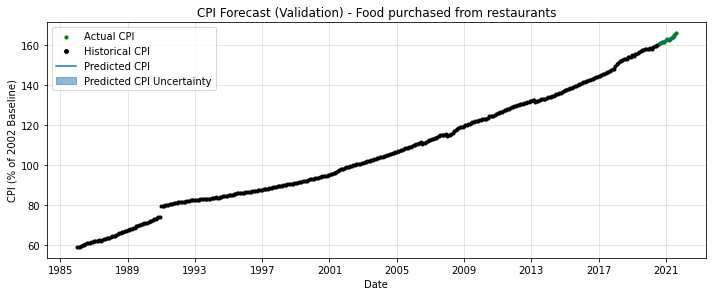

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    8.82e-01
mae         3.61e-01
mape        2.21e-03
mse         2.72e-01
rmse        5.22e-01
dtype: float64


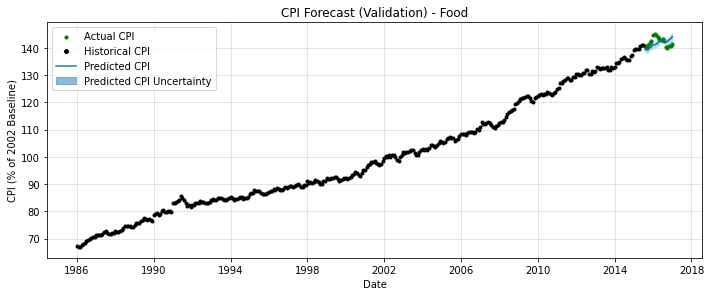

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.85
mae         1.89
mape        0.01
mse         4.72
rmse        2.17
dtype: float64


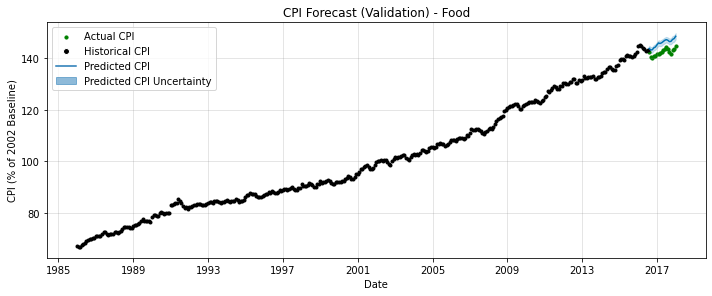

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.30
mae          3.49
mape         0.02
mse         12.70
rmse         3.56
dtype: float64


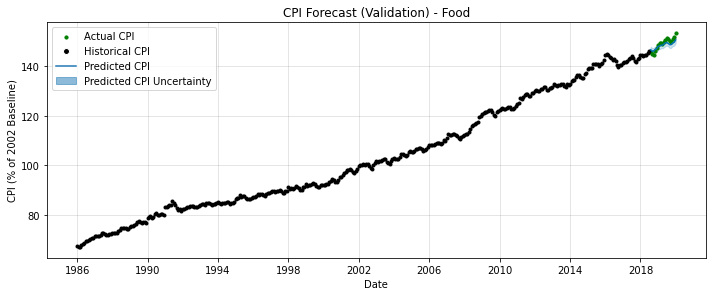

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    6.75e-01
mae         1.24e+00
mape        8.27e-03
mse         1.92e+00
rmse        1.38e+00
dtype: float64


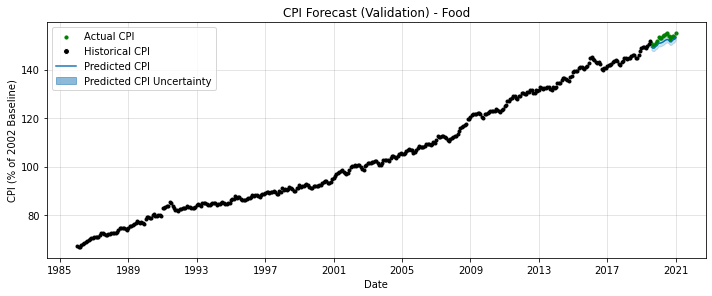

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.67
mae         1.90
mape        0.01
mse         3.90
rmse        1.98
dtype: float64


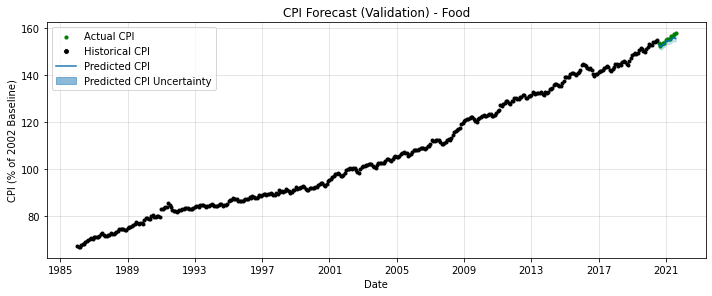

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    5.71e-01
mae         9.37e-01
mape        6.01e-03
mse         1.15e+00
rmse        1.07e+00
dtype: float64


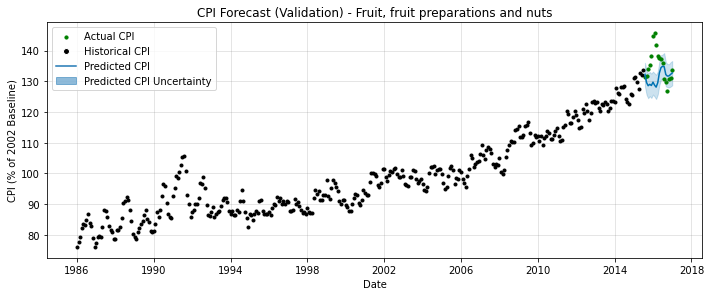

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.23
mae          5.63
mape         0.04
mse         56.86
rmse         7.54
dtype: float64


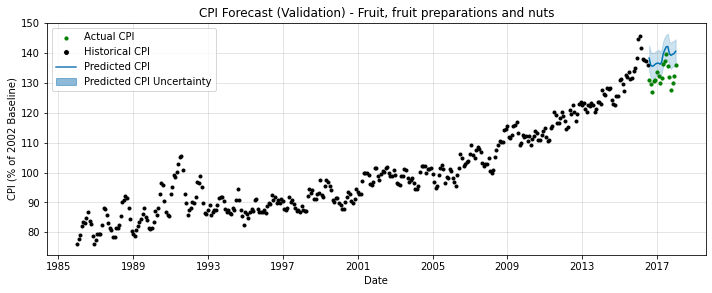

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.85
mae          6.05
mape         0.05
mse         42.20
rmse         6.50
dtype: float64


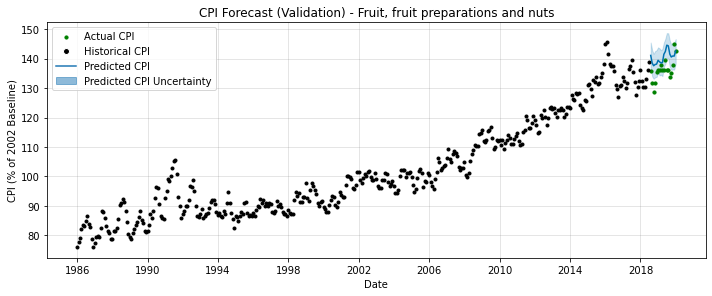

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.15
mae          4.66
mape         0.03
mse         28.35
rmse         5.32
dtype: float64


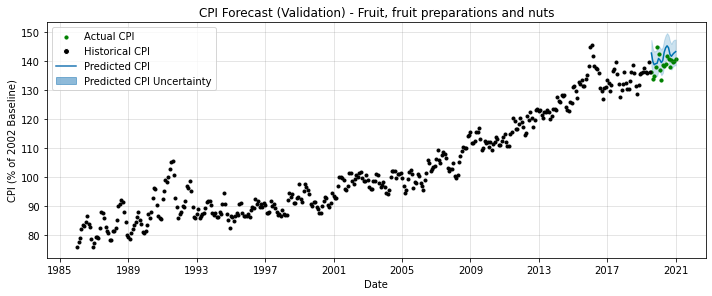

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.02
mae          3.76
mape         0.03
mse         17.06
rmse         4.13
dtype: float64


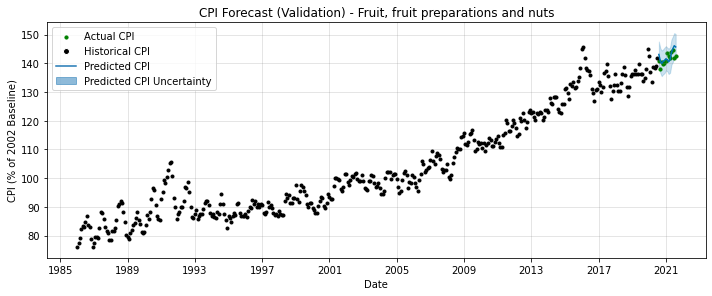

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.32
mae         1.60
mape        0.01
mse         4.04
rmse        2.01
dtype: float64


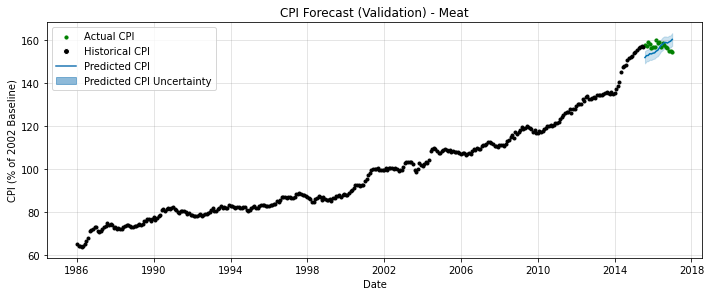

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -5.71
mae          3.50
mape         0.02
mse         15.23
rmse         3.90
dtype: float64


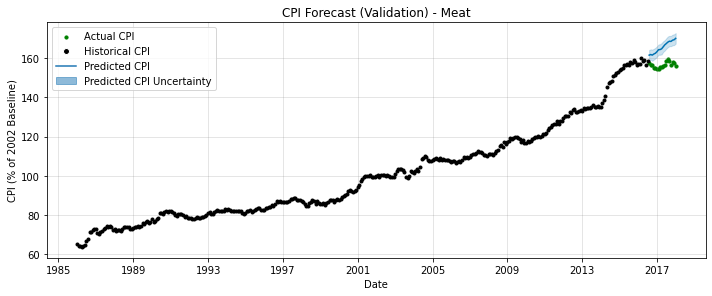

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -40.94
mae          9.08
mape         0.06
mse         88.51
rmse         9.41
dtype: float64


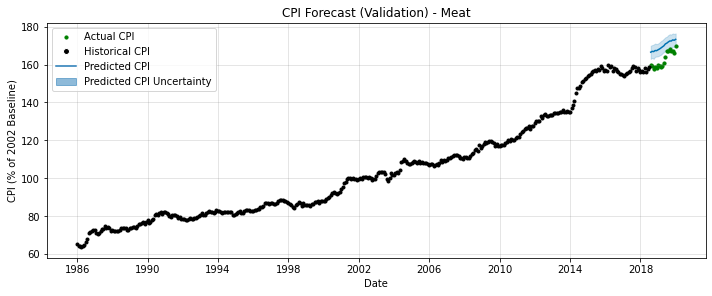

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.24
mae          7.13
mape         0.04
mse         55.20
rmse         7.43
dtype: float64


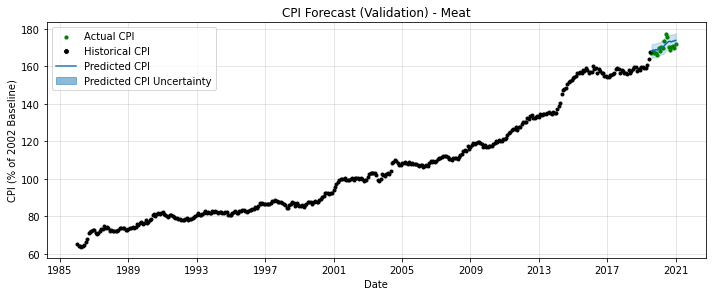

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.20
mae         2.09
mape        0.01
mse         6.40
rmse        2.53
dtype: float64


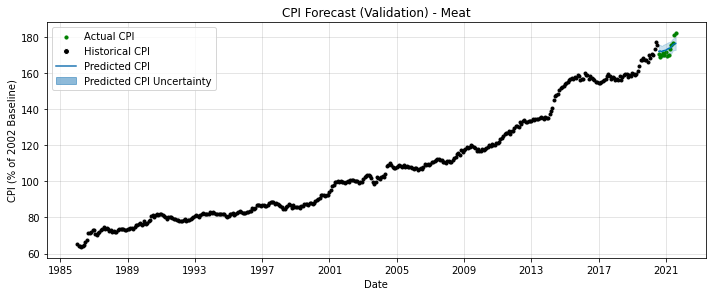

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.53
mae         2.40
mape        0.01
mse         8.37
rmse        2.89
dtype: float64


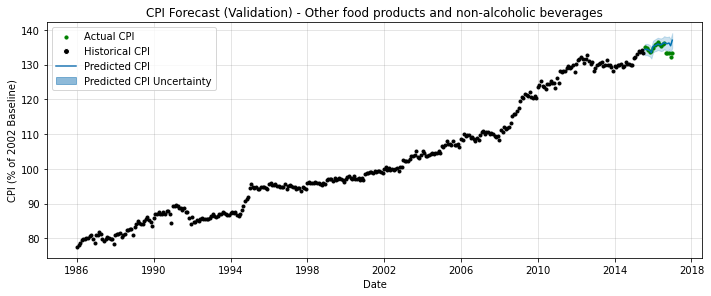

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.57e-01
mae         1.08e+00
mape        8.09e-03
mse         2.66e+00
rmse        1.63e+00
dtype: float64


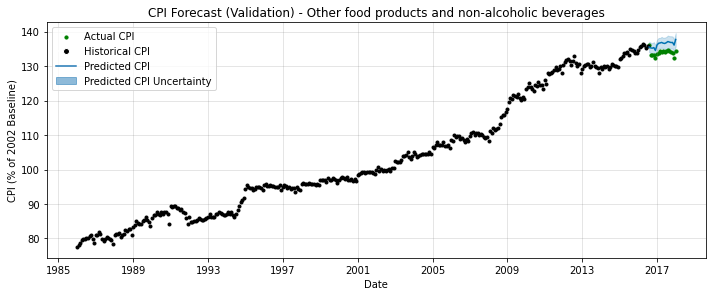

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.21
mae         2.48
mape        0.02
mse         6.52
rmse        2.55
dtype: float64


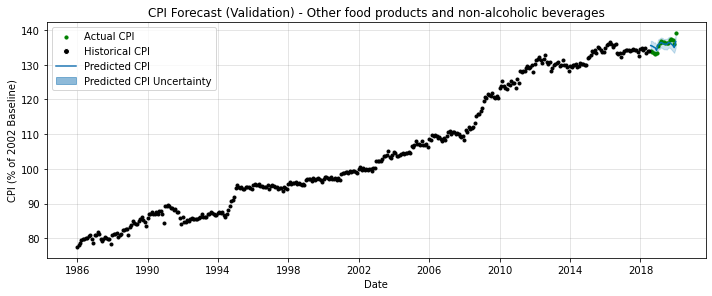

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    4.68e-01
mae         9.49e-01
mape        7.00e-03
mse         1.40e+00
rmse        1.18e+00
dtype: float64


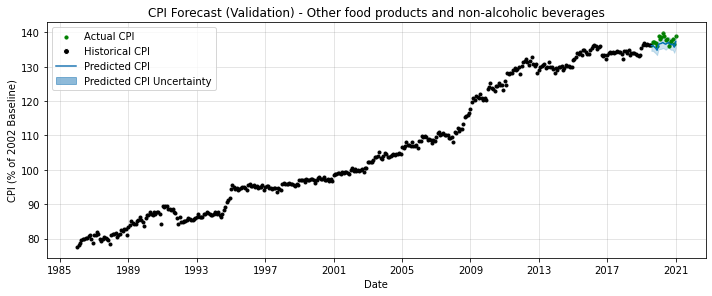

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.93
mae         1.39
mape        0.01
mse         2.37
rmse        1.54
dtype: float64


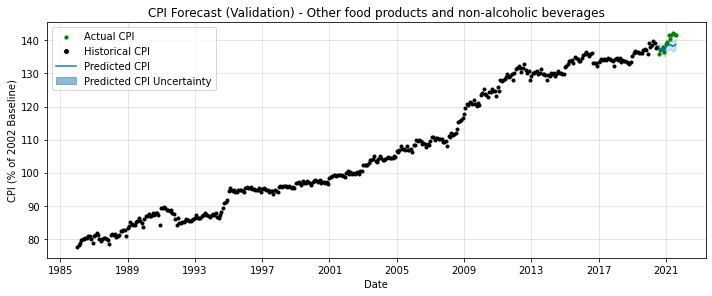

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.04
mae         1.79
mape        0.01
mse         4.92
rmse        2.22
dtype: float64


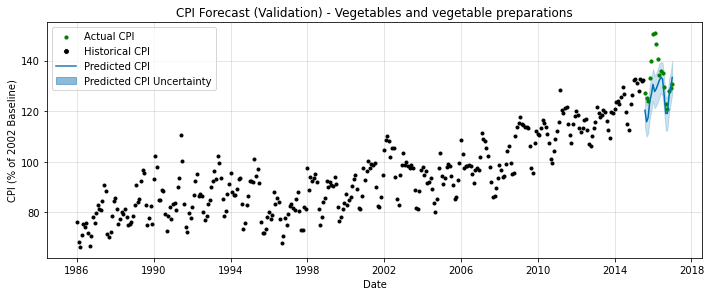

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.30
mae           7.59
mape          0.05
mse         102.48
rmse         10.12
dtype: float64


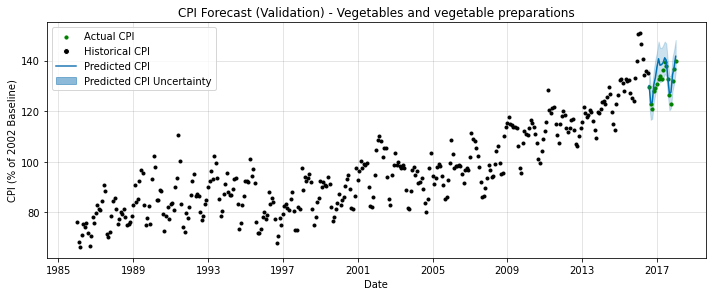

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.57
mae          2.89
mape         0.02
mse         12.96
rmse         3.60
dtype: float64


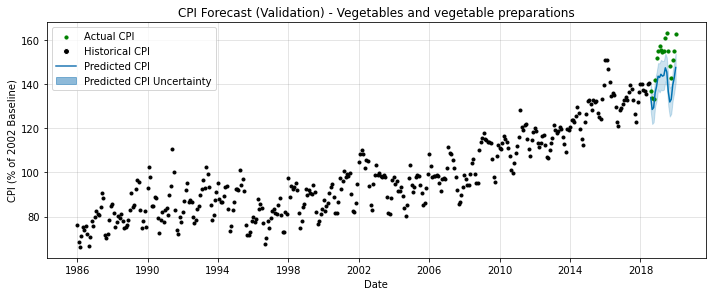

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.77
mae          11.27
mape          0.07
mse         146.06
rmse         12.09
dtype: float64


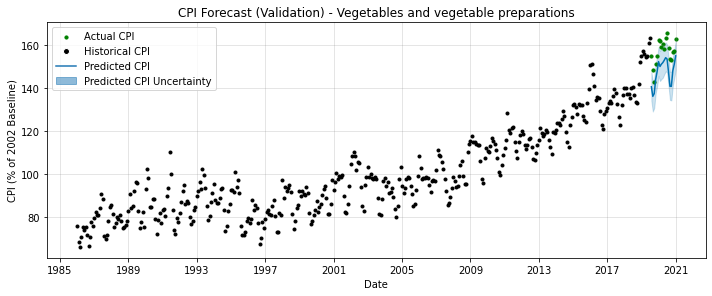

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.03
mae          9.40
mape         0.06
mse         95.35
rmse         9.76
dtype: float64


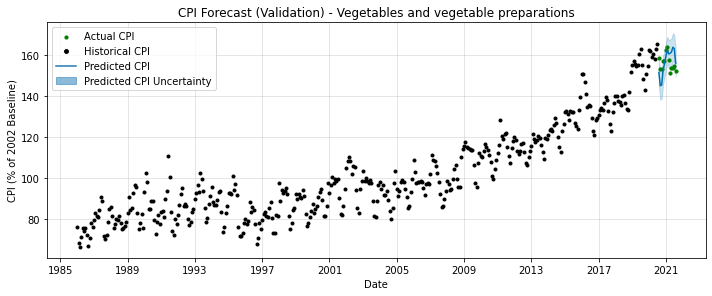

r2_score    -2.10
mae          5.82
mape         0.04
mse         42.86
rmse         6.55
dtype: float64


In [ ]:
all_valid_metrics = {}

for food_category in foodprice_df.columns:

    annual_valid_metrics = {}

    for date in report_sim_dates:  

        train_dates = sim_train_dates[date]
        valid_dates = sim_valid_dates[date]

        model, valid_forecast, valid_metrics = fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates)
        valid_actual = get_prophet_df(foodprice_df, food_category, valid_dates) 

        plot_valid_forecast(model, food_category, valid_forecast, valid_actual)
        valid_metrics_series = pd.Series(valid_metrics)
        print(valid_metrics_series)

        annual_valid_metrics[date] = valid_metrics_series

    all_valid_metrics[food_category] = annual_valid_metrics

In [ ]:
pd.DataFrame(all_valid_metrics['Food']).mean(axis=1)

NameError: ignored

In [ ]:
valid_metrics_df = pd.DataFrame(all_valid_metrics).T
valid_metrics_df.to_csv(f"{output_path}/fc_valid_metrics.csv")
valid_metrics_df

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-33.73,14.20,0.09,245.06,15.65
Dairy products and eggs,-4.72,7.98,0.06,74.38,8.62
"Fish, seafood and other marine products",-0.28,8.22,0.06,74.39,8.62
Food purchased from restaurants,0.78,3.27,0.02,17.85,4.22
Food,0.88,1.81,0.01,4.47,2.11
"Fruit, fruit preparations and nuts",0.11,3.74,0.03,24.77,4.98
Meat,0.20,5.27,0.03,45.02,6.71
Other food products and non-alcoholic beverages,-16.46,10.78,0.08,136.28,11.67
Vegetables and vegetable preparations,0.05,10.44,0.07,169.53,13.02


## Fit Models Using All Data To Produce Final Forecast

In [ ]:
def fit_final_forecast_model(foodprice_df, food_category, all_dates):
    train_df = get_prophet_df(foodprice_df, food_category, all_dates)       # Select data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    future = model.make_future_dataframe(periods=18, freq='MS')             # Create the future period. 
    forecast = model.predict(future.iloc[-18:])                             # Produce the future period forecast. 
    historical_fit = model.predict(future.iloc[:-18])                       # Look at how well the model fits the data.
    return model, forecast, historical_fit

In [ ]:
def plot_final_forecast(model, forecast, historical_fit):

    fig = model.plot(forecast, figsize=(10,4))
    ax = fig.axes[0]

    ax.plot(historical_fit.ds, historical_fit.yhat, alpha=0.5, color='purple', label='Historical Model Fit')
    ax.fill_between(historical_fit.ds, historical_fit.yhat_lower, historical_fit.yhat_upper, 
                    alpha=0.2, color='purple', label='Historical Model Fit Uncertainty')
    ax.set_title(f'CPI Forecast - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_final_{food_category}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_final_{food_category}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


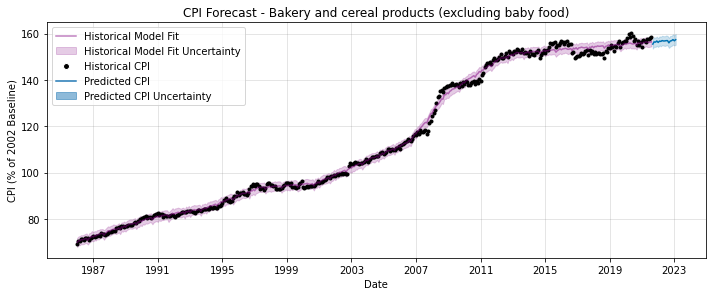

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


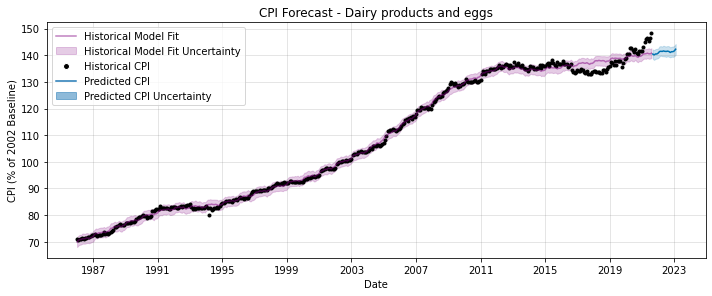

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


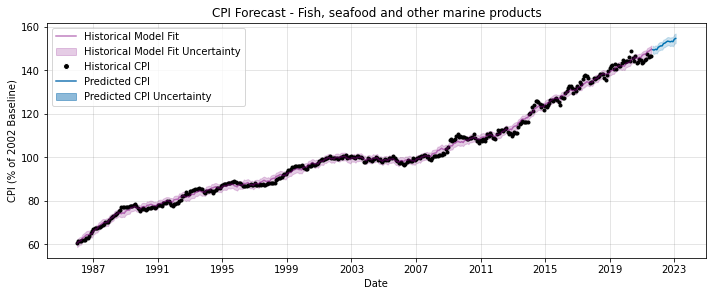

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


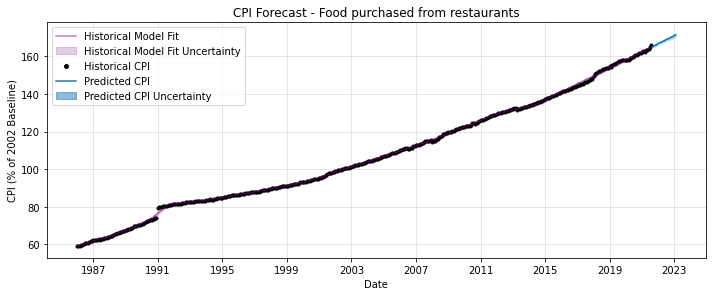

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


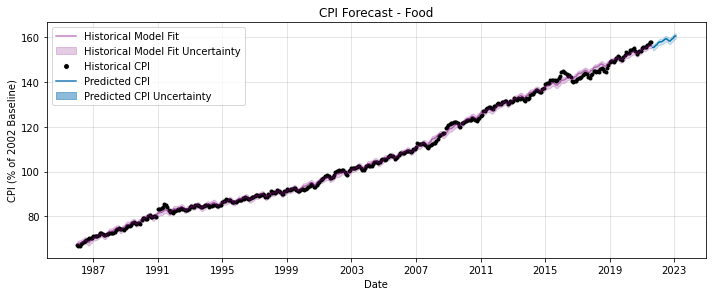

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


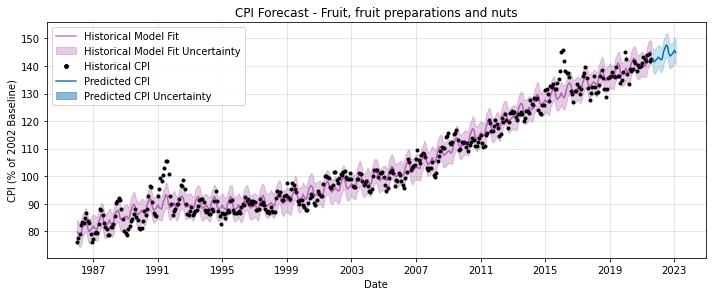

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


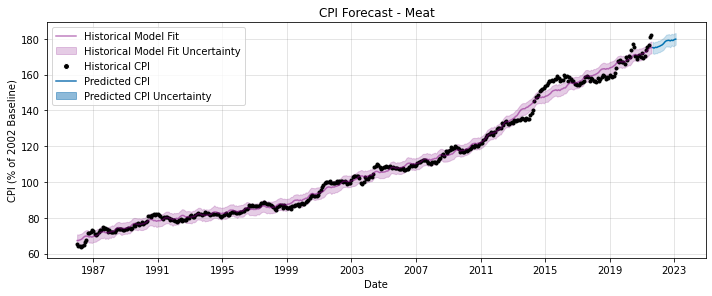

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


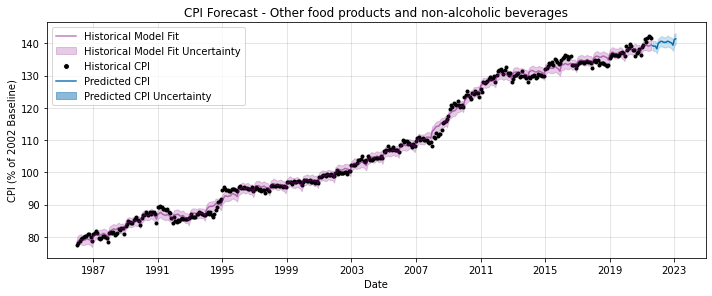

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


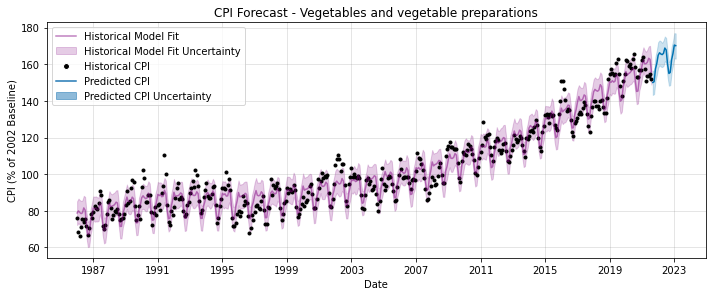

In [ ]:
all_forecasts = {}

for food_category in foodprice_df.columns:

    model, forecast, historical_fit = fit_final_forecast_model(foodprice_df, food_category, all_dates=foodprice_df.index)
    plot_final_forecast(model, forecast, historical_fit)
    forecast.to_csv(f"{output_path}/fc_final_raw_{food_category}.csv")
    all_forecasts[food_category] = forecast

In [ ]:
### Show all forecast details for Meat, as an example. 
all_forecasts['Meat']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-01,174.77,171.85,178.39,174.77,174.77,0.33,0.33,0.33,0.33,0.33,0.33,0.0,0.0,0.0,175.10
1,2021-10-01,175.10,171.61,177.86,175.10,175.10,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,0.0,0.0,0.0,174.83
2,2021-11-01,175.44,172.01,178.41,175.44,175.44,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,0.0,0.0,0.0,175.28
3,2021-12-01,175.76,171.93,178.36,175.76,175.76,-0.60,-0.60,-0.60,-0.60,-0.60,-0.60,0.0,0.0,0.0,175.16
4,2022-01-01,176.10,172.51,178.94,176.09,176.13,-0.50,-0.50,-0.50,-0.50,-0.50,-0.50,0.0,0.0,0.0,175.60
5,2022-02-01,176.44,172.54,178.99,176.41,176.49,-0.61,-0.61,-0.61,-0.61,-0.61,-0.61,0.0,0.0,0.0,175.83
6,2022-03-01,176.74,173.02,179.46,176.69,176.82,-0.51,-0.51,-0.51,-0.51,-0.51,-0.51,0.0,0.0,0.0,176.23
7,2022-04-01,177.08,173.38,179.96,177.01,177.19,-0.46,-0.46,-0.46,-0.46,-0.46,-0.46,0.0,0.0,0.0,176.62
8,2022-05-01,177.40,173.93,180.50,177.31,177.55,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,0.0,0.0,0.0,177.28
9,2022-06-01,177.74,175.05,181.33,177.61,177.92,0.50,0.50,0.50,0.50,0.50,0.50,0.0,0.0,0.0,178.24


## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.

In [ ]:
historical_cpi_df = foodprice_df['Meat']
historical_cpi_df

REF_DATE
1986-01-01     65.1
1986-02-01     64.2
1986-03-01     64.2
1986-04-01     63.6
1986-05-01     64.0
              ...  
2021-04-01    173.5
2021-05-01    175.4
2021-06-01    176.7
2021-07-01    180.9
2021-08-01    182.1
Freq: MS, Name: Meat, Length: 428, dtype: float64

In [ ]:
forecast_cpi_df = all_forecasts['Meat'][['ds', 'yhat']].set_index('ds')['yhat']
forecast_cpi_df

ds
2021-09-01    175.10
2021-10-01    174.83
2021-11-01    175.28
2021-12-01    175.16
2022-01-01    175.60
2022-02-01    175.83
2022-03-01    176.23
2022-04-01    176.62
2022-05-01    177.28
2022-06-01    178.24
2022-07-01    178.86
2022-08-01    179.07
2022-09-01    179.17
2022-10-01    178.84
2022-11-01    179.27
2022-12-01    179.01
2023-01-01    179.60
2023-02-01    179.83
Name: yhat, dtype: float64

In [ ]:
combined_cpi_df = historical_cpi_df.append(forecast_cpi_df)
combined_cpi_df

1986-01-01     65.10
1986-02-01     64.20
1986-03-01     64.20
1986-04-01     63.60
1986-05-01     64.00
               ...  
2022-10-01    178.84
2022-11-01    179.27
2022-12-01    179.01
2023-01-01    179.60
2023-02-01    179.83
Length: 446, dtype: float64